## Import Driver

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import neccesary libraries

In [ ]:
import os
import scipy.io
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

## Download images data and extract it

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar

--2024-08-05 10:33:16--  http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1345040896 (1.3G) [application/x-tar]
Saving to: ‘VOCtrainval_03-May-2010.tar’

VOCtrainval_03-May- 100%[===================>]   1.25G  22.1MB/s    in 64s     

2024-08-05 10:34:21 (20.2 MB/s) - ‘VOCtrainval_03-May-2010.tar’ saved [1345040896/1345040896]



In [ ]:
import tarfile

tar_file_path = 'VOCtrainval_03-May-2010.tar'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall()

## Download mask data and extract it

In [ ]:
# download mask images
!wget https://cs.stanford.edu/~roozbeh/pascal-context/trainval.tar.gz
!tar -xvzf trainval.tar.gz

Streaming output truncated to the last 5000 lines.
trainval/2009_002851.mat
trainval/2008_004670.mat
trainval/2010_002678.mat
trainval/2009_003234.mat
trainval/2008_001649.mat
trainval/2010_001544.mat
trainval/2009_003067.mat
trainval/2008_004983.mat
trainval/2008_005414.mat
trainval/2009_002808.mat
trainval/2008_000190.mat
trainval/2009_002431.mat
trainval/2008_006956.mat
trainval/2008_004756.mat
trainval/2010_004345.mat
trainval/2010_005480.mat
trainval/2010_003771.mat
trainval/2010_004698.mat
trainval/2009_004648.mat
trainval/2008_005699.mat
trainval/2010_000588.mat
trainval/2010_000401.mat
trainval/2010_000285.mat
trainval/2010_002513.mat
trainval/2008_000078.mat
trainval/2008_005945.mat
trainval/2010_001671.mat
trainval/2009_001664.mat
trainval/2010_004259.mat
trainval/2009_003466.mat
trainval/2009_003982.mat
trainval/2010_002708.mat
trainval/2008_004934.mat
trainval/2008_002700.mat
trainval/2010_001608.mat
trainval/2008_006815.mat
trainval/2008_007521.mat
trainval/2009_003224.mat

## Set root directory for images and masks

In [ ]:
# Images and mask directory
image_dir = 'VOCdevkit/VOC2010/JPEGImages/'
mask_dir = 'trainval/'

## Read images and Mask paths

In [ ]:
# Get the list of images and masks
mask_paths = sorted([fname for fname in os.listdir(mask_dir) if fname.endswith('.mat')])
image_paths = sorted([fname.replace('.mat', '.jpg') for fname in os.listdir(mask_dir) if os.path.exists(os.path.join(image_dir, fname.replace('.mat', '.jpg')))])

# Check if the number of images matches the number of masks
assert len(image_paths) == len(mask_paths), "The number of images and masks should be the same."

paired_image_paths = [os.path.join(image_dir, fname) for fname in image_paths]
paired_mask_paths = [os.path.join(mask_dir, fname) for fname in mask_paths]

## Preproccessing images and masks

In [ ]:
# Load .mat file and extract label map
def load_mat_file(mat_file_path):
    mat = scipy.io.loadmat(mat_file_path)
    label_map = mat['LabelMap']
    return label_map

# Load image from file path
def load_image(image_path):
    image = load_img(image_path)
    return img_to_array(image)

# Resize image and mask
def resize_image_and_mask(image, mask, target_size):
    # Resize image
    image = Image.fromarray(image.astype('uint8')).resize(target_size, Image.BILINEAR)
    image = np.array(image)

    # Resize mask using nearest neighbor interpolation
    mask = Image.fromarray(mask.astype('uint16')).resize(target_size, Image.NEAREST)
    mask = np.array(mask)

    return image, mask

## One-hot encode masks

In [ ]:
# One-hot encode the label map
def one_hot_encode(label_map, num_classes):
    one_hot = np.zeros((label_map.shape[0], label_map.shape[1], num_classes), dtype=np.uint8)
    for c in range(num_classes):
        one_hot[:, :, c] = (label_map == c).astype(np.uint8)
    return one_hot

## Data generator using image and mask paths

In [ ]:
# Data generator using paired paths
def data_generator(paired_image_paths, paired_mask_paths, batch_size, num_classes, target_size):
    while True:
        for i in range(0, len(paired_image_paths), batch_size):
            batch_images_paths = paired_image_paths[i:i+batch_size]
            batch_masks_paths = paired_mask_paths[i:i+batch_size]

            images = []
            masks = []

            for img_path, mask_path in zip(batch_images_paths, batch_masks_paths):
                image = load_image(img_path)
                label_map = load_mat_file(mask_path)

                # Resize image and mask
                image, label_map = resize_image_and_mask(image, label_map, target_size)

                mask = one_hot_encode(label_map, num_classes)

                images.append(image)
                masks.append(mask)

            yield np.array(images), np.array(masks)

## Function for display some sample of image and mask side by side

In [ ]:
# Display samples function
def display_samples(image_paths, mask_paths, num_samples=10, target_size=(256, 256), num_classes=459):
    sample_indices = np.random.choice(len(image_paths), num_samples, replace=False)

    plt.figure(figsize=(20, num_samples * 5))

    for i, idx in enumerate(sample_indices):
        img_path = image_paths[idx]
        mask_path = mask_paths[idx]

        image = load_image(img_path)
        label_map = load_mat_file(mask_path)

        # Resize image and mask
        image, label_map = resize_image_and_mask(image, label_map, target_size)

        mask = one_hot_encode(label_map, num_classes)
        mask_rgb = np.argmax(mask, axis=-1)

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(image.astype(np.uint8))
        plt.title("Image")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(mask_rgb, cmap='jet', alpha=0.5)
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Split dataset for train, validation and test with 70, 20, 10%

In [ ]:
# Split into training (70%) and temp (30%)
train_image_paths, temp_image_paths, train_mask_paths, temp_mask_paths = train_test_split(
    paired_image_paths, paired_mask_paths, test_size=0.3, random_state=42)

# Split temp into validation (2/3 of 30% -> 20% of total) and test (1/3 of 30% -> 10% of total)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(
    temp_image_paths, temp_mask_paths, test_size=0.33, random_state=42)

# Check the lengths
print(f"Training set size: {len(train_image_paths)}")
print(f"Validation set size: {len(val_image_paths)}")
print(f"Test set size: {len(test_image_paths)}")

Training set size: 7072
Validation set size: 2030
Test set size: 1001


## Create data generator

In [ ]:
# Create data generators
batch_size = 32
target_size = (128, 128)
num_classes = 459

train_gen = data_generator(train_image_paths, train_mask_paths, batch_size, num_classes, target_size)
val_gen = data_generator(val_image_paths, val_mask_paths, batch_size, num_classes, target_size)
test_gen = data_generator(test_image_paths, test_mask_paths, batch_size, num_classes, target_size)

## Display 10 samples of dataset

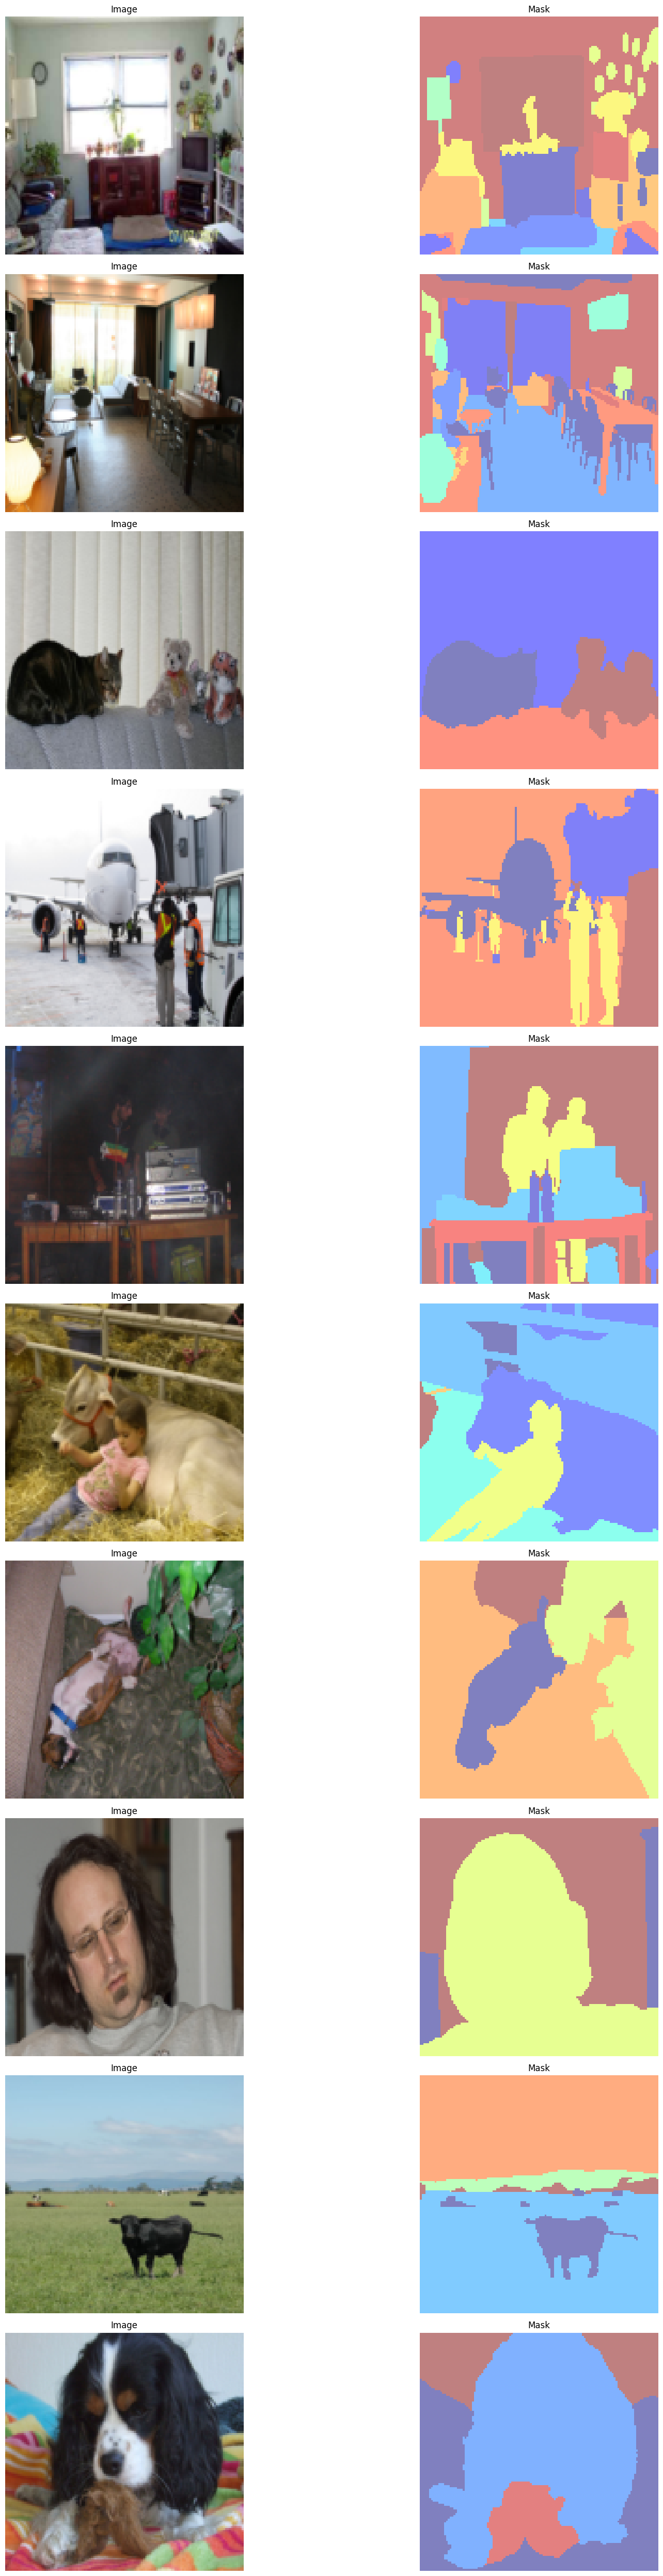

In [ ]:
# Display samples
display_samples(paired_image_paths, paired_mask_paths, num_samples=10, target_size=target_size, num_classes=num_classes)

## Fetch one batch to check

In [ ]:
# Fetch one batch to check
images, masks = next(train_gen)
print(images.shape)  # Should be (batch_size, target_height, target_width, 3)
print(masks.shape)   # Should be (batch_size, target_height, target_width, num_classes)

(32, 128, 128, 3)
(32, 128, 128, 459)


## Define U-Net model

In [ ]:
# Define U-Net model
def unet_model(input_size=(128, 128, 3), num_classes=459):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model


# Initialize U-Net model
model = unet_model(input_size=(target_size[0], target_size[1], 3), num_classes=num_classes)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,408,715 (119.81 MB)

 Trainable params: 31,408,715 (119.81 MB)

 Non-trainable params: 0 (0.00 B)

## Define checkpoint callback

In [ ]:
# Define the model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    'unet_model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras',  # File name to save the model
    monitor='val_loss',       # Monitor the validation loss
    verbose=1,                # Verbosity mode, 1 to show messages
    save_best_only=False,     # Save all models, not just the best one
    mode='auto'               # Mode for monitoring the metric
)

In [ ]:
# Define the custom callback to evaluate on test data
class TestCallback(Callback):
    def __init__(self, test_gen, num_test_samples, target_size, num_classes):
        self.test_gen = test_gen
        self.num_test_samples = num_test_samples
        self.target_size = target_size
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEvaluating on test data at the end of epoch {epoch + 1}")
        test_images, test_masks = next(self.test_gen)
        predicted_masks = self.model.predict(test_images)

        plt.figure(figsize=(20, 5 * self.num_test_samples))
        for i in range(self.num_test_samples):
            plt.subplot(self.num_test_samples, 3, 3*i + 1)
            plt.imshow(test_images[i].astype(np.uint8))
            plt.title("Input Image")
            plt.axis('off')

            plt.subplot(self.num_test_samples, 3, 3*i + 2)
            true_mask_rgb = np.argmax(test_masks[i], axis=-1)
            plt.imshow(true_mask_rgb, cmap='jet', alpha=0.5)
            plt.title("True Mask")
            plt.axis('off')

            plt.subplot(self.num_test_samples, 3, 3*i + 3)
            predicted_mask_rgb = np.argmax(predicted_masks[i], axis=-1)
            plt.imshow(predicted_mask_rgb, cmap='jet', alpha=0.5)
            plt.title("Predicted Mask")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Define the custom callback
num_test_samples = 3  # Number of test samples to display
test_callback = TestCallback(test_gen, num_test_samples, target_size, num_classes)

## Train the model

Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1126 - loss: 28.0184
Epoch 1: saving model to unet_model_epoch_01_val_loss_3.3347.keras

Evaluating on test data at the end of epoch 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


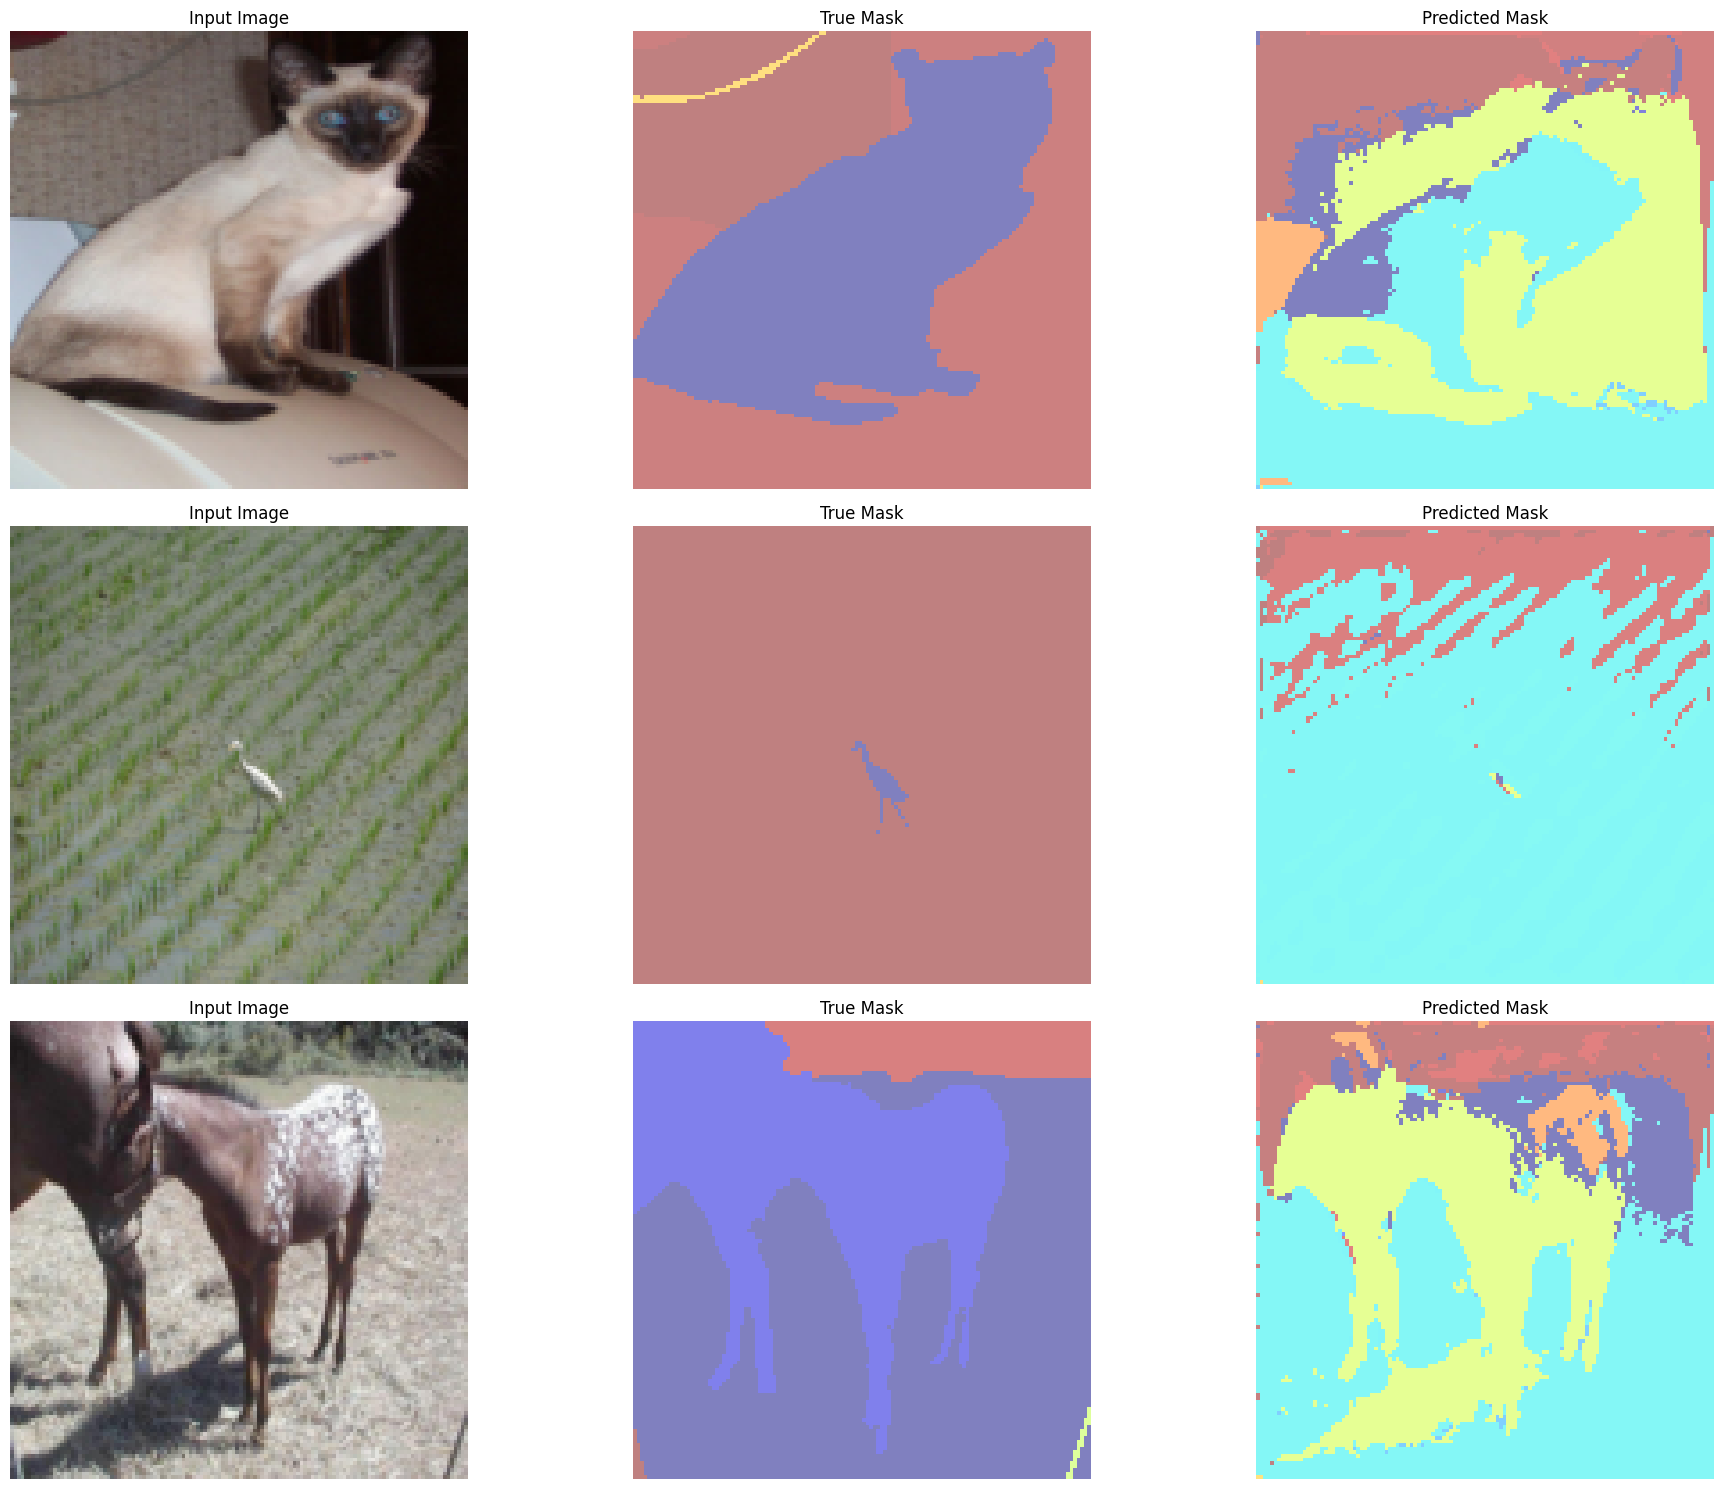

221/221 ━━━━━━━━━━━━━━━━━━━━ 666s 3s/step - accuracy: 0.1128 - loss: 27.9307 - val_accuracy: 0.2353 - val_loss: 3.3347
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2452 - loss: 3.2579
Epoch 2: saving model to unet_model_epoch_02_val_loss_3.1360.keras

Evaluating on test data at the end of epoch 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


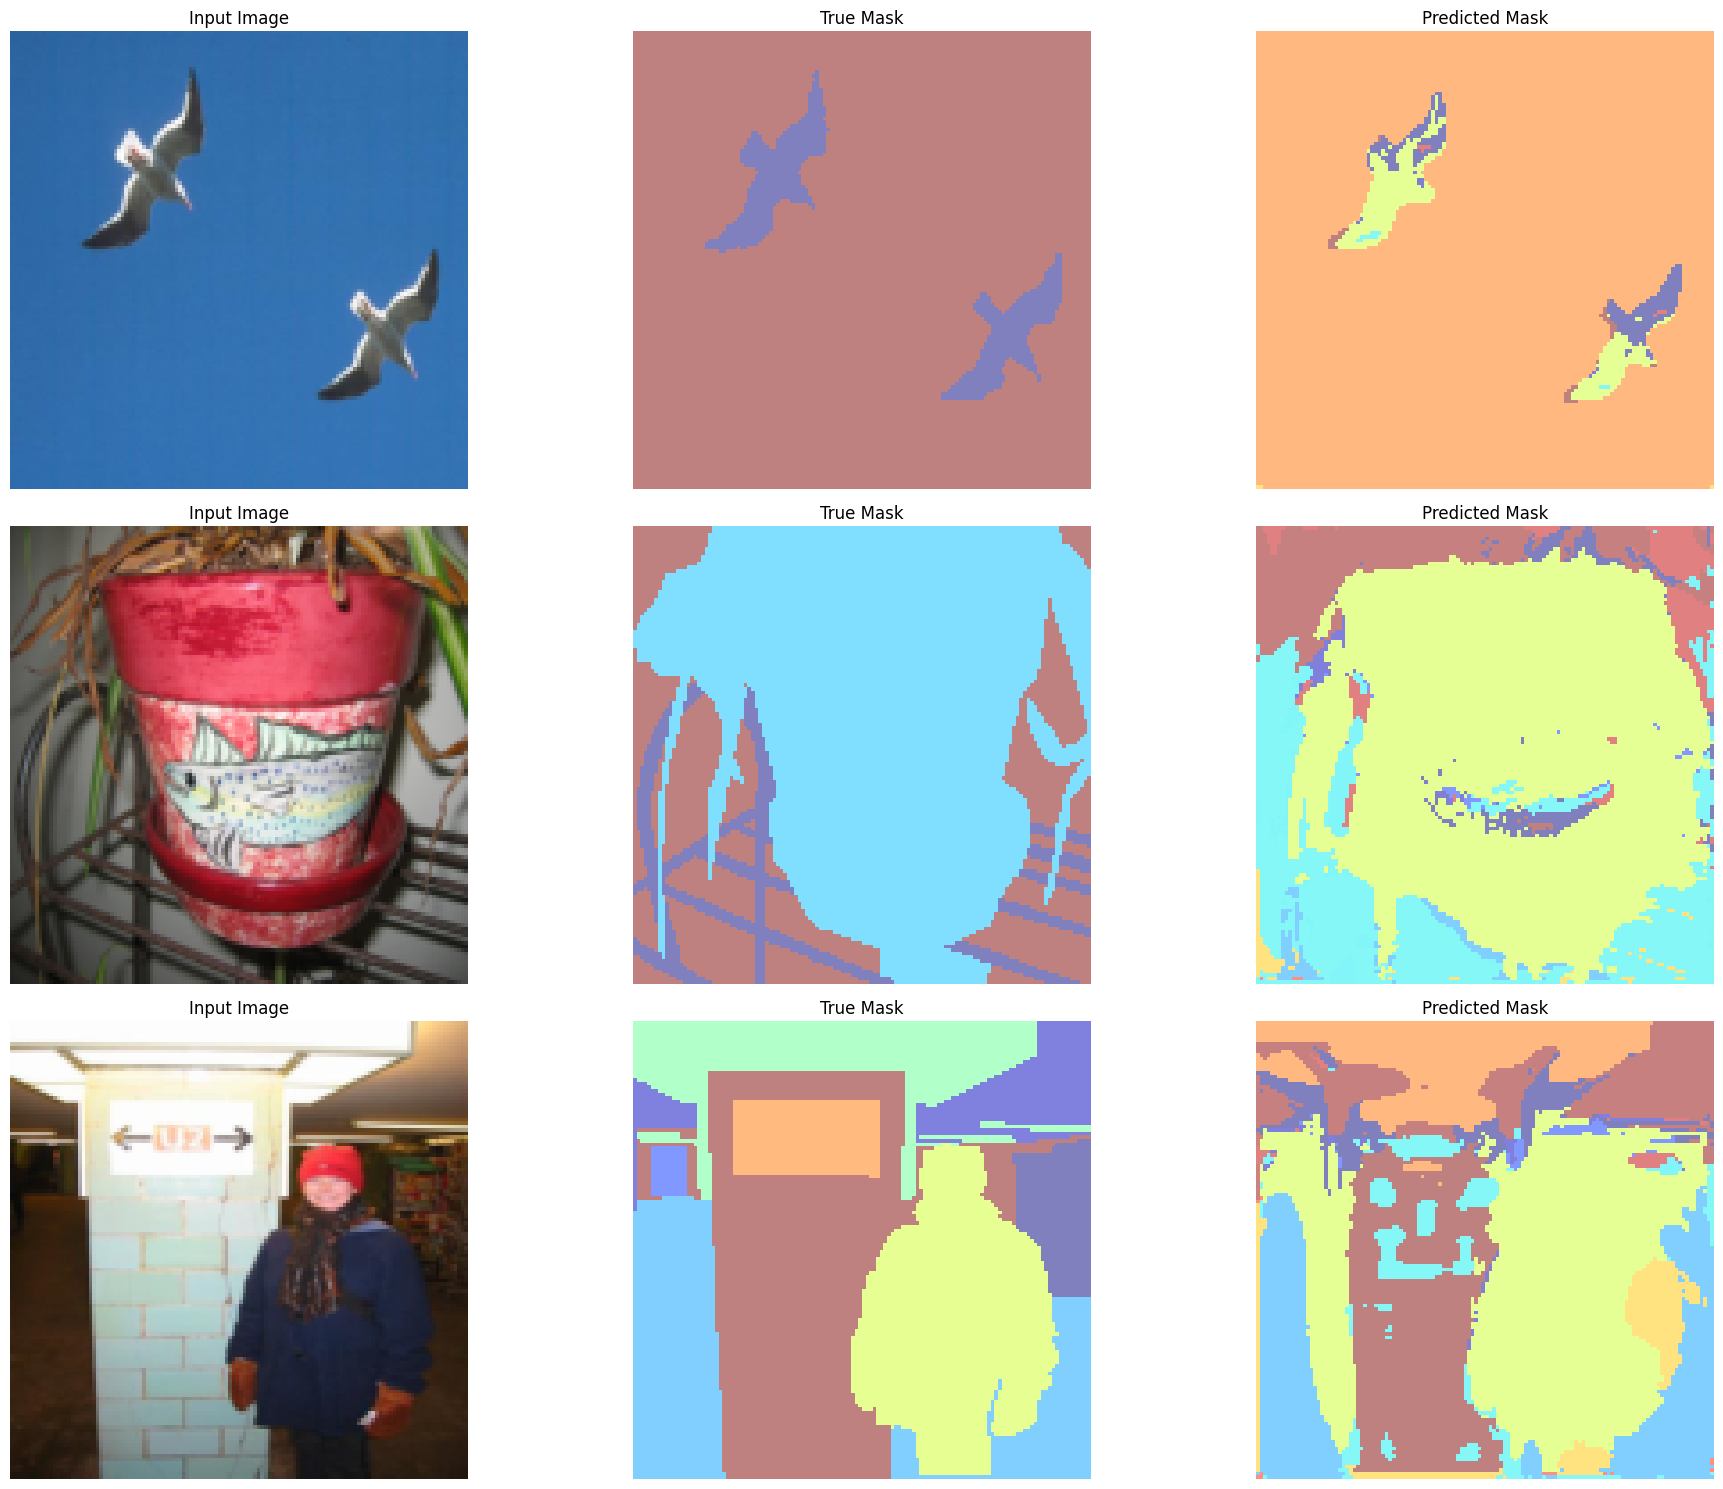

221/221 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.2452 - loss: 3.2576 - val_accuracy: 0.2679 - val_loss: 3.1360
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2644 - loss: 3.1264
Epoch 3: saving model to unet_model_epoch_03_val_loss_3.0856.keras

Evaluating on test data at the end of epoch 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


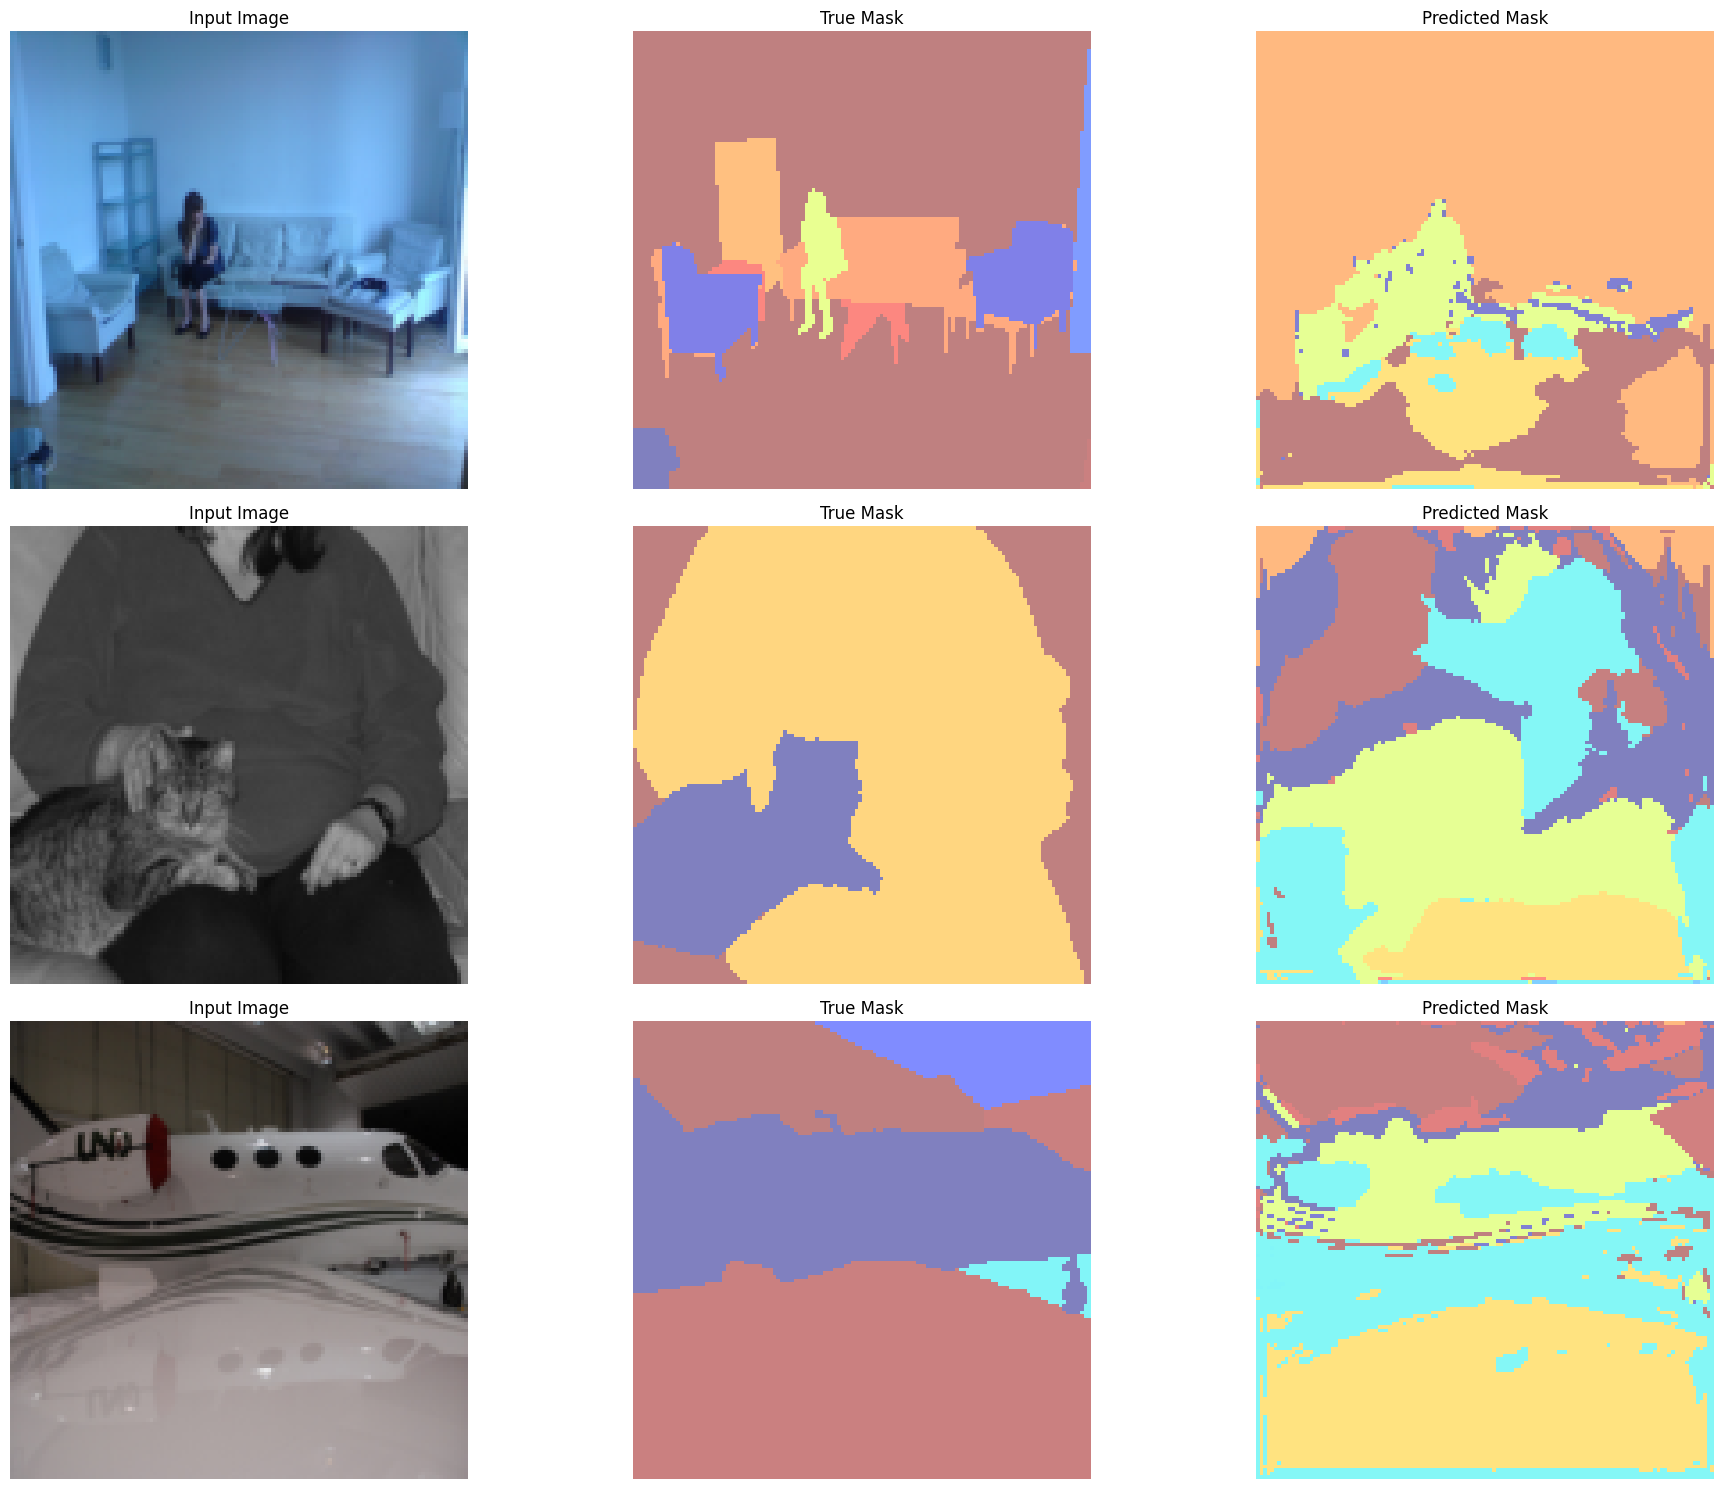

221/221 ━━━━━━━━━━━━━━━━━━━━ 600s 3s/step - accuracy: 0.2644 - loss: 3.1262 - val_accuracy: 0.2721 - val_loss: 3.0856
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2788 - loss: 3.0390
Epoch 4: saving model to unet_model_epoch_04_val_loss_3.0252.keras

Evaluating on test data at the end of epoch 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


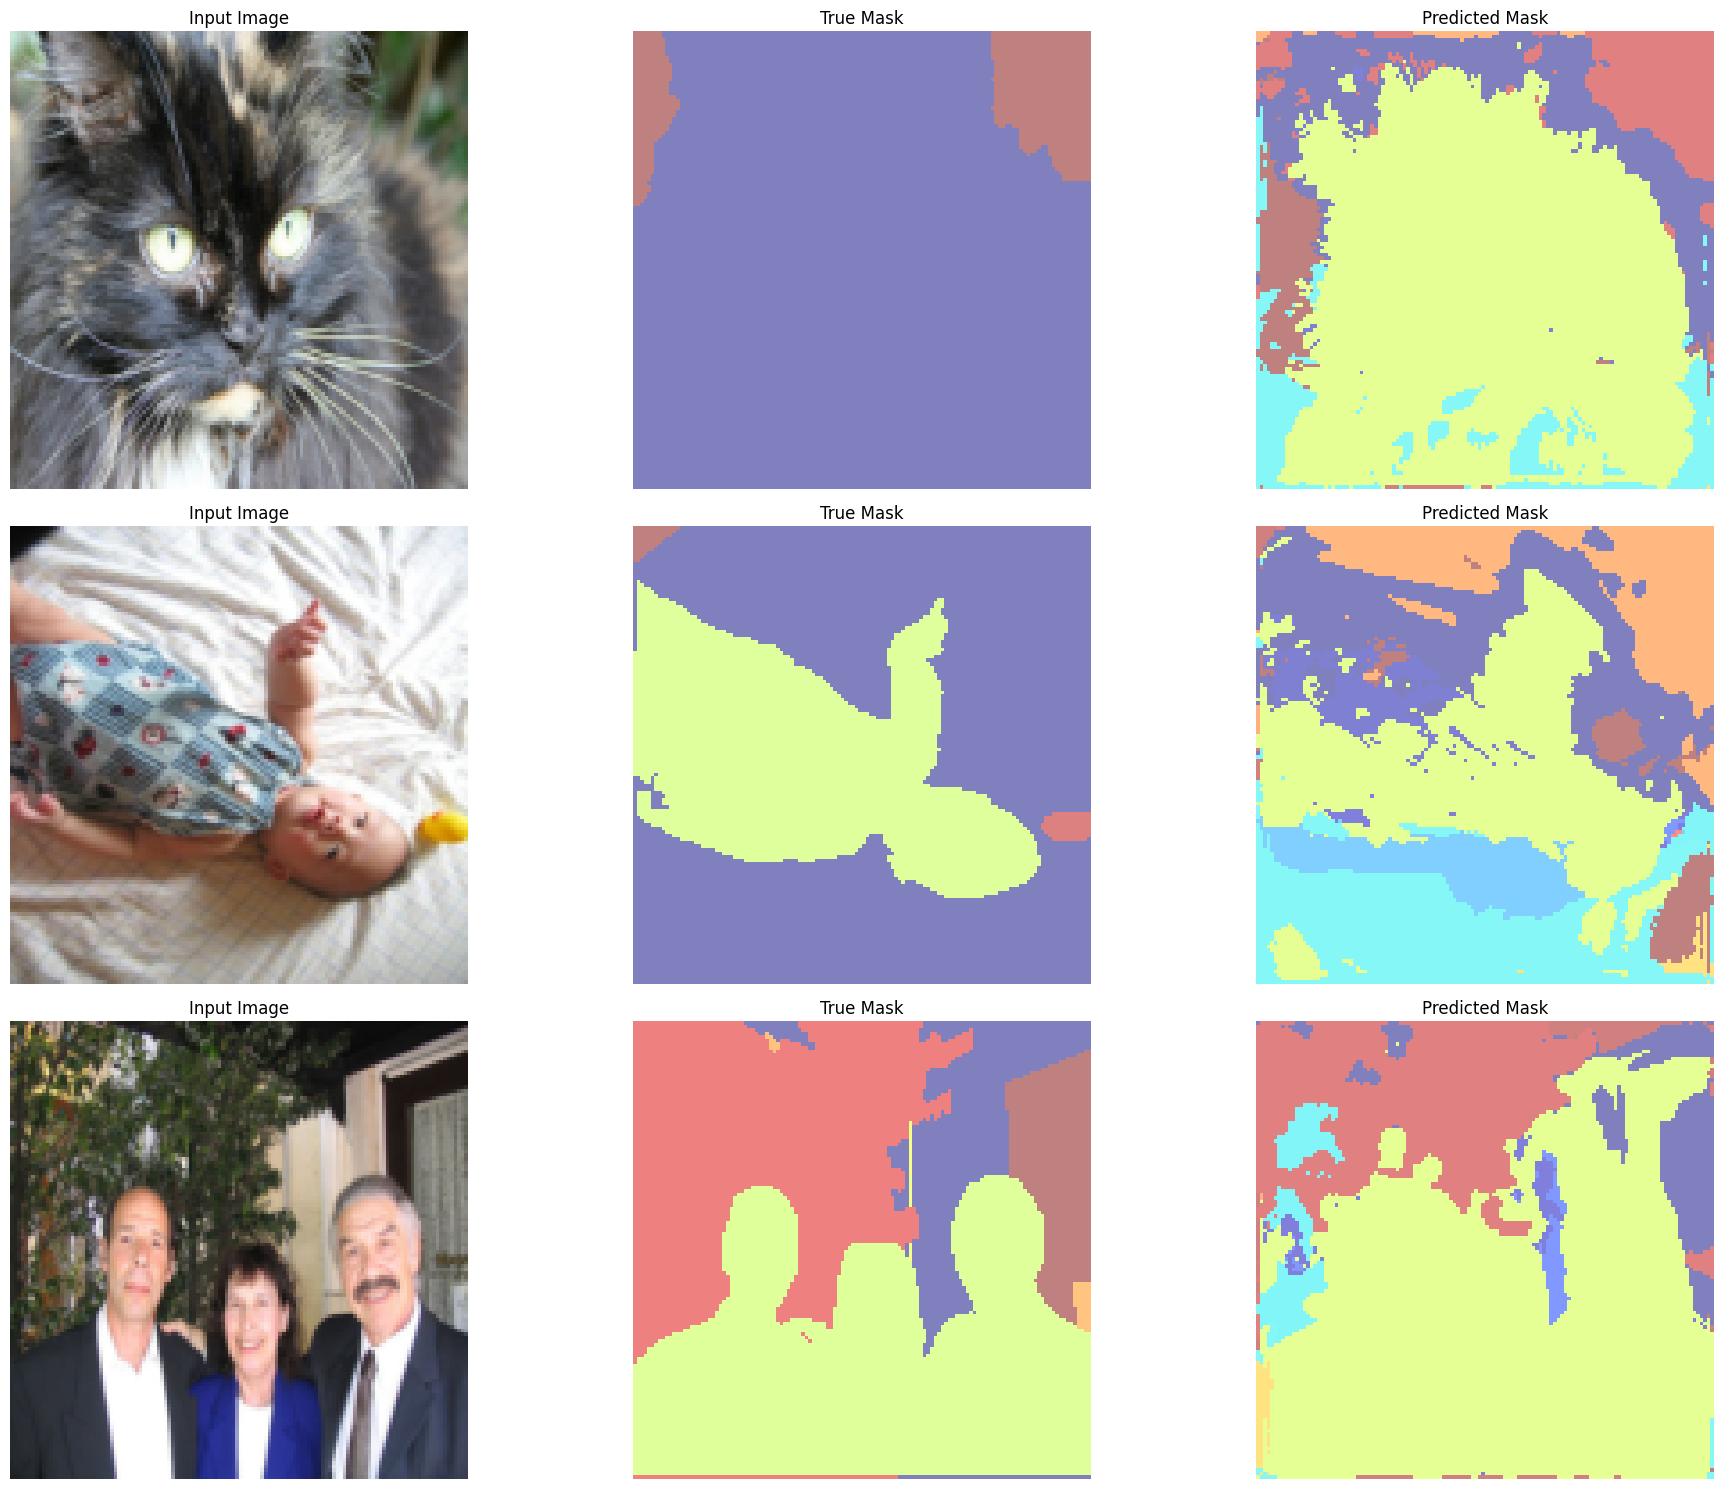

221/221 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.2788 - loss: 3.0388 - val_accuracy: 0.2816 - val_loss: 3.0252
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2924 - loss: 2.9656
Epoch 5: saving model to unet_model_epoch_05_val_loss_2.8953.keras

Evaluating on test data at the end of epoch 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


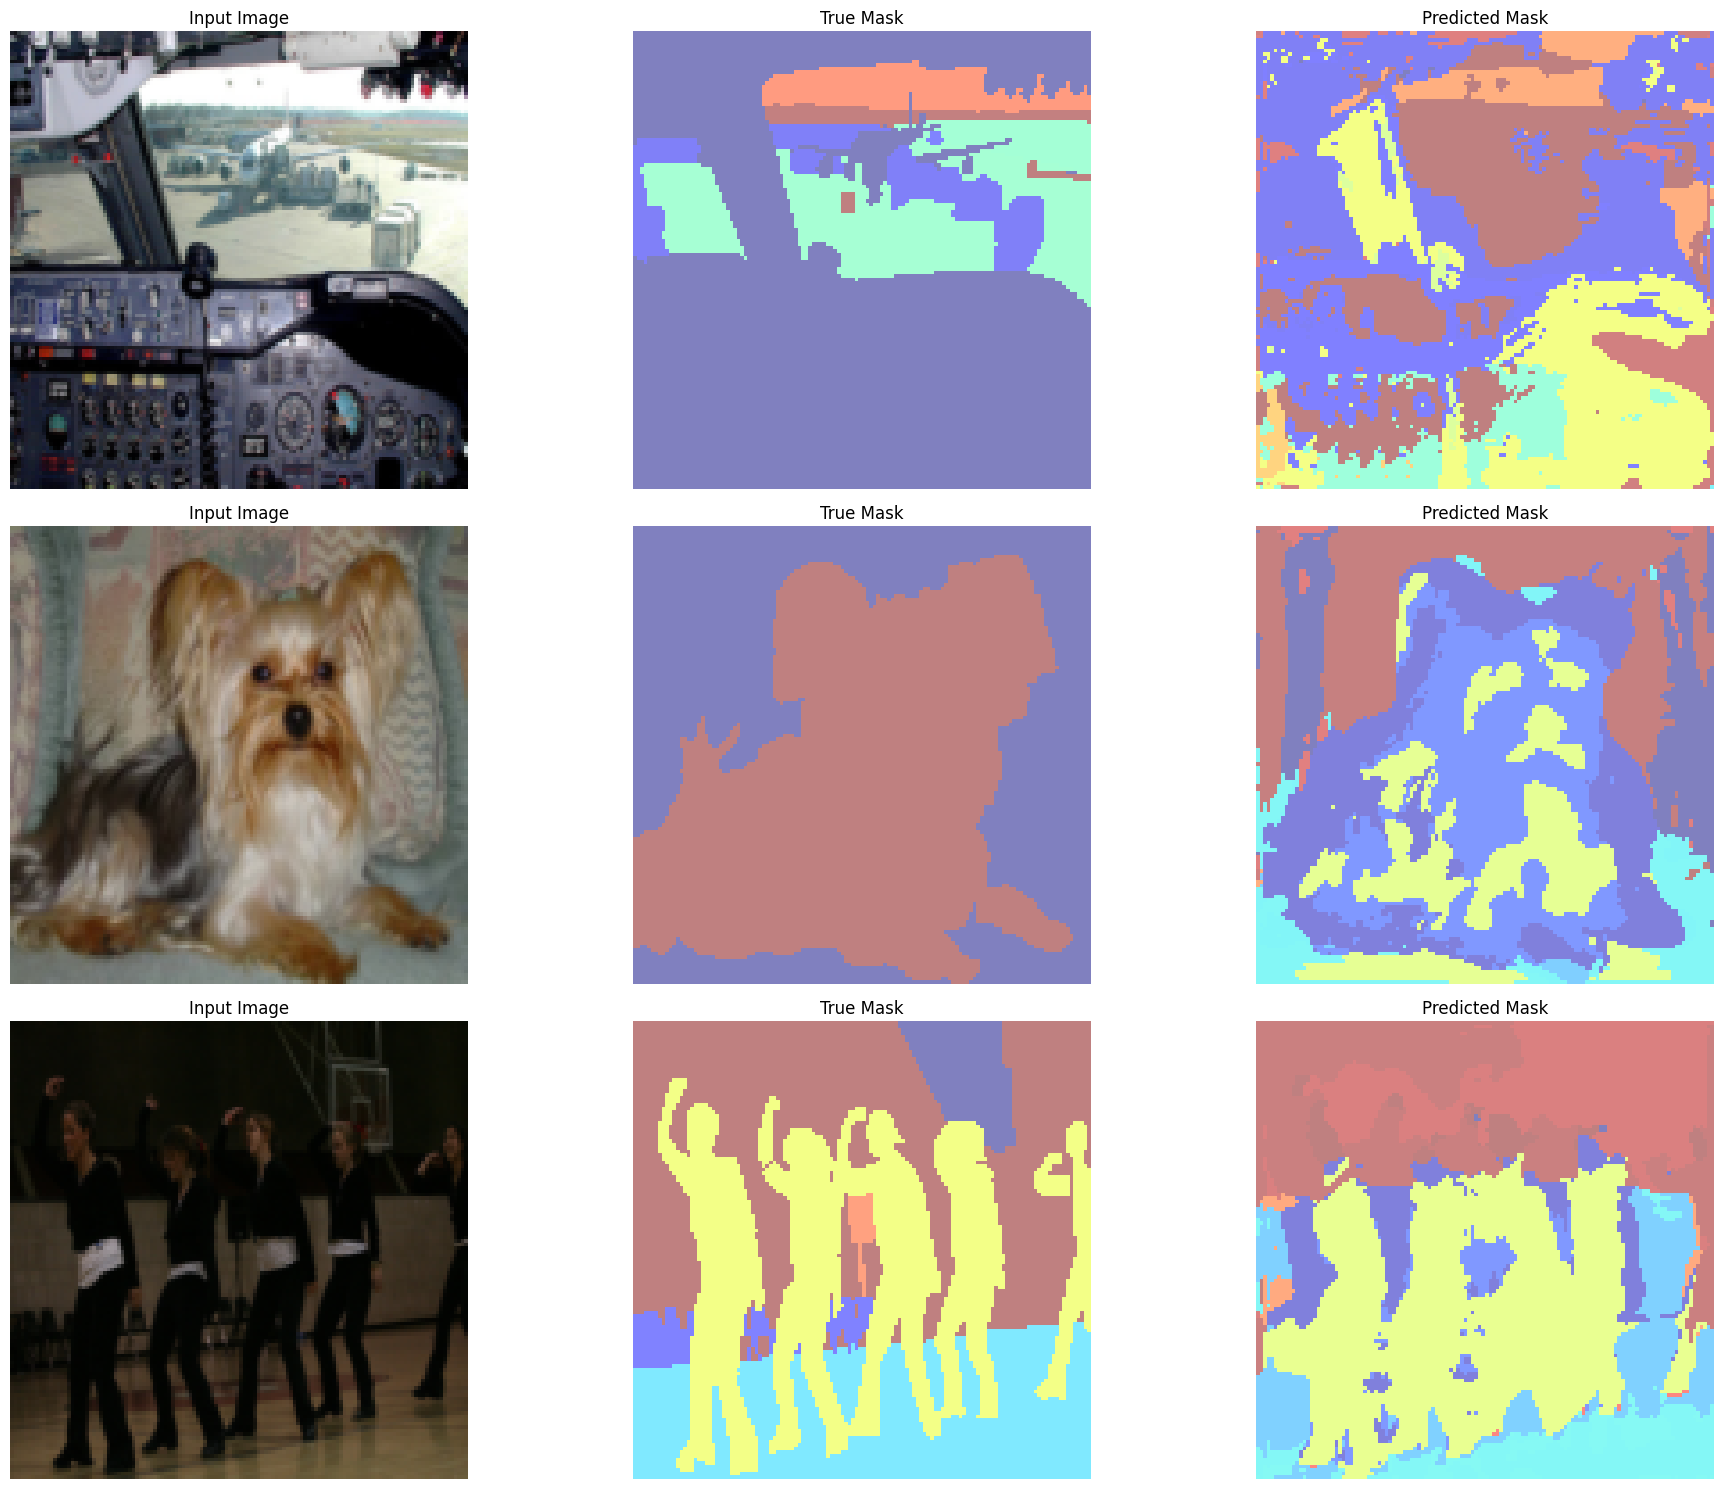

221/221 ━━━━━━━━━━━━━━━━━━━━ 571s 3s/step - accuracy: 0.2924 - loss: 2.9655 - val_accuracy: 0.3072 - val_loss: 2.8953
Epoch 6/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3086 - loss: 2.8824
Epoch 6: saving model to unet_model_epoch_06_val_loss_2.8493.keras

Evaluating on test data at the end of epoch 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


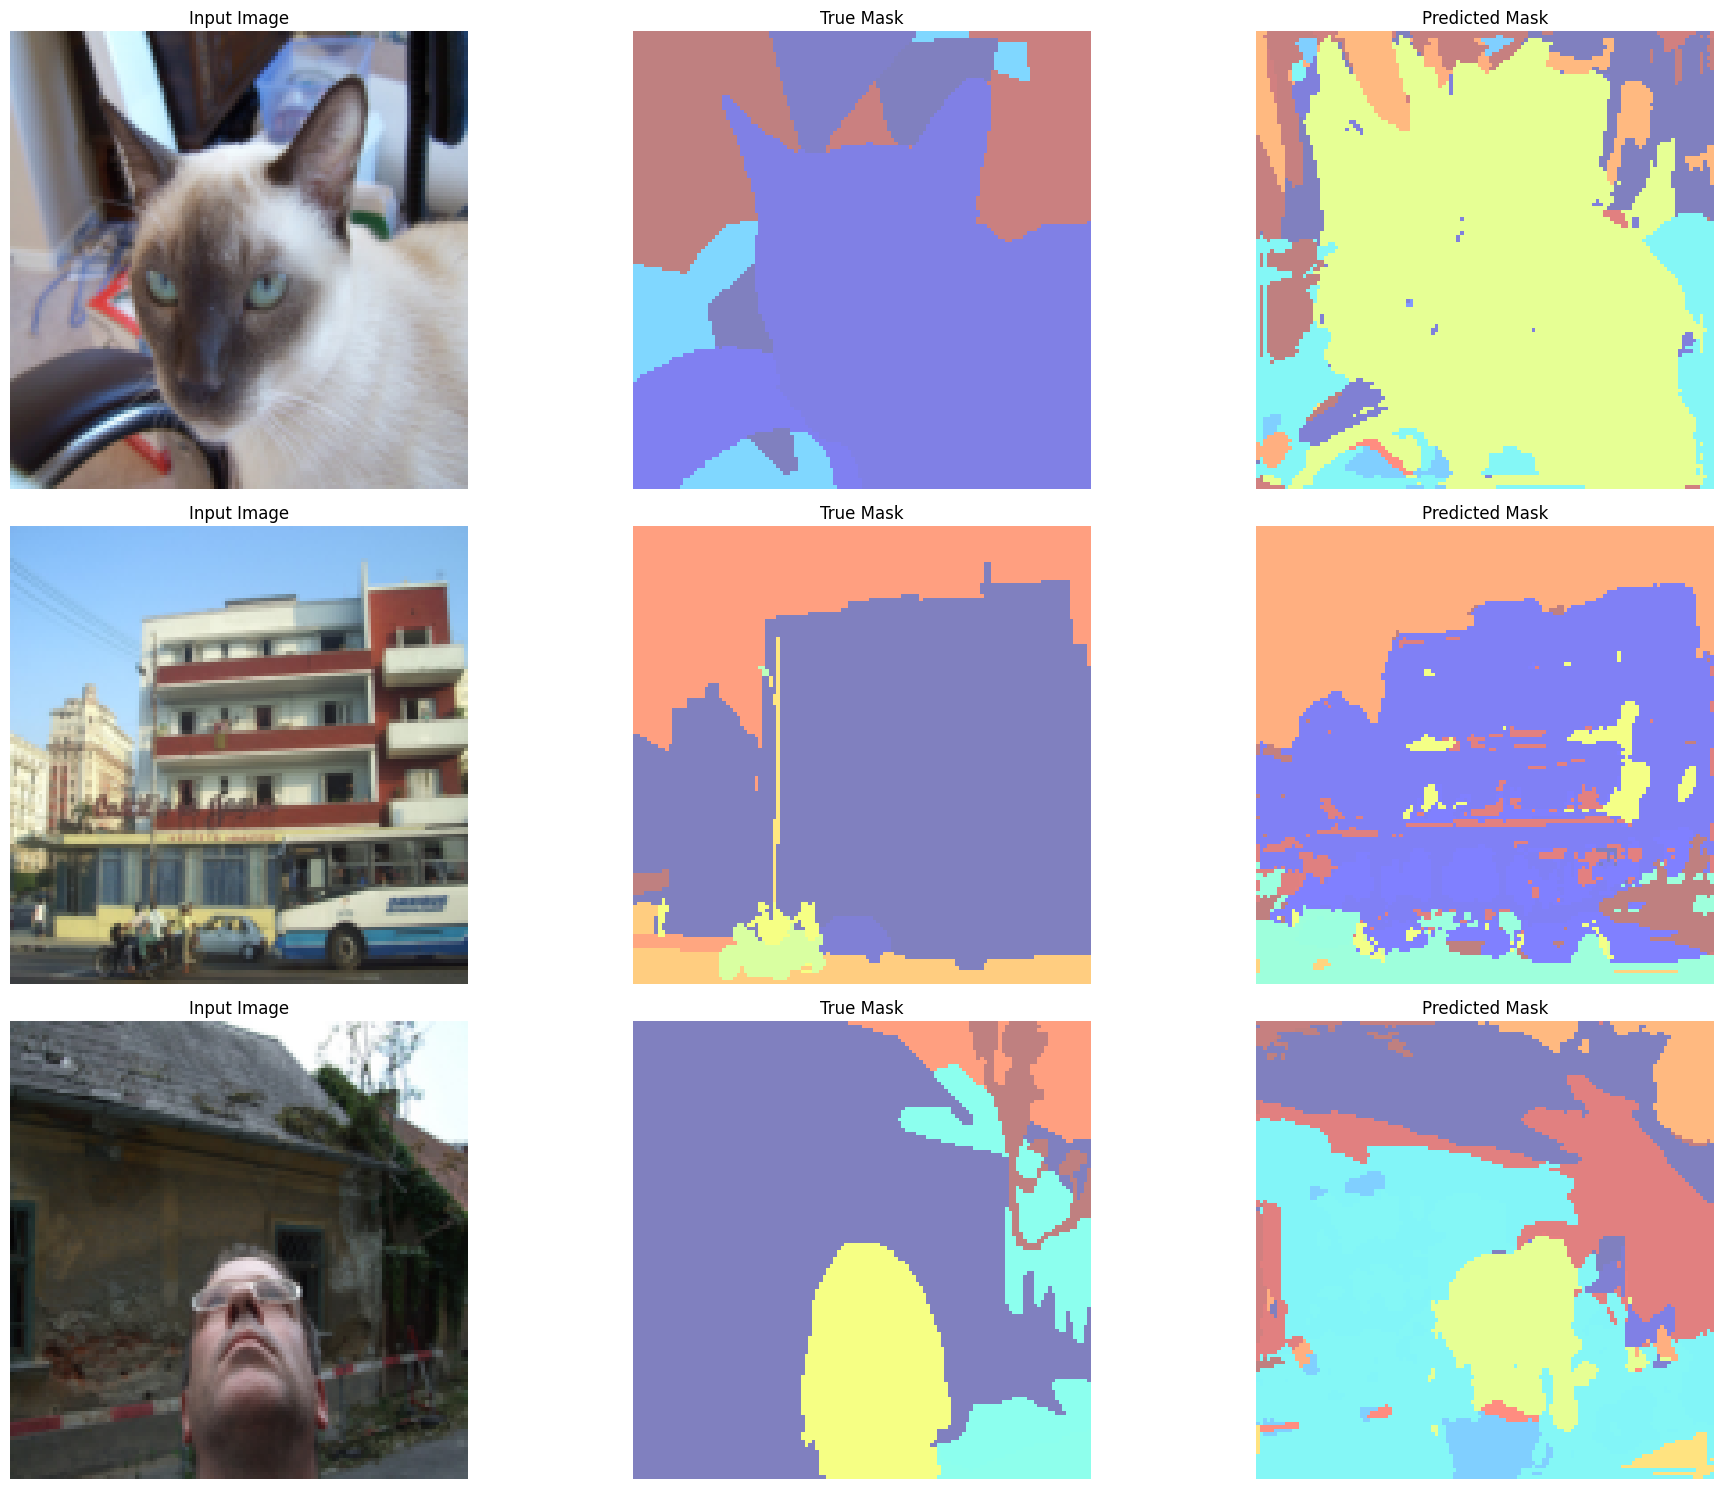

221/221 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - accuracy: 0.3086 - loss: 2.8822 - val_accuracy: 0.3171 - val_loss: 2.8493
Epoch 7/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3238 - loss: 2.8035
Epoch 7: saving model to unet_model_epoch_07_val_loss_2.8086.keras

Evaluating on test data at the end of epoch 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


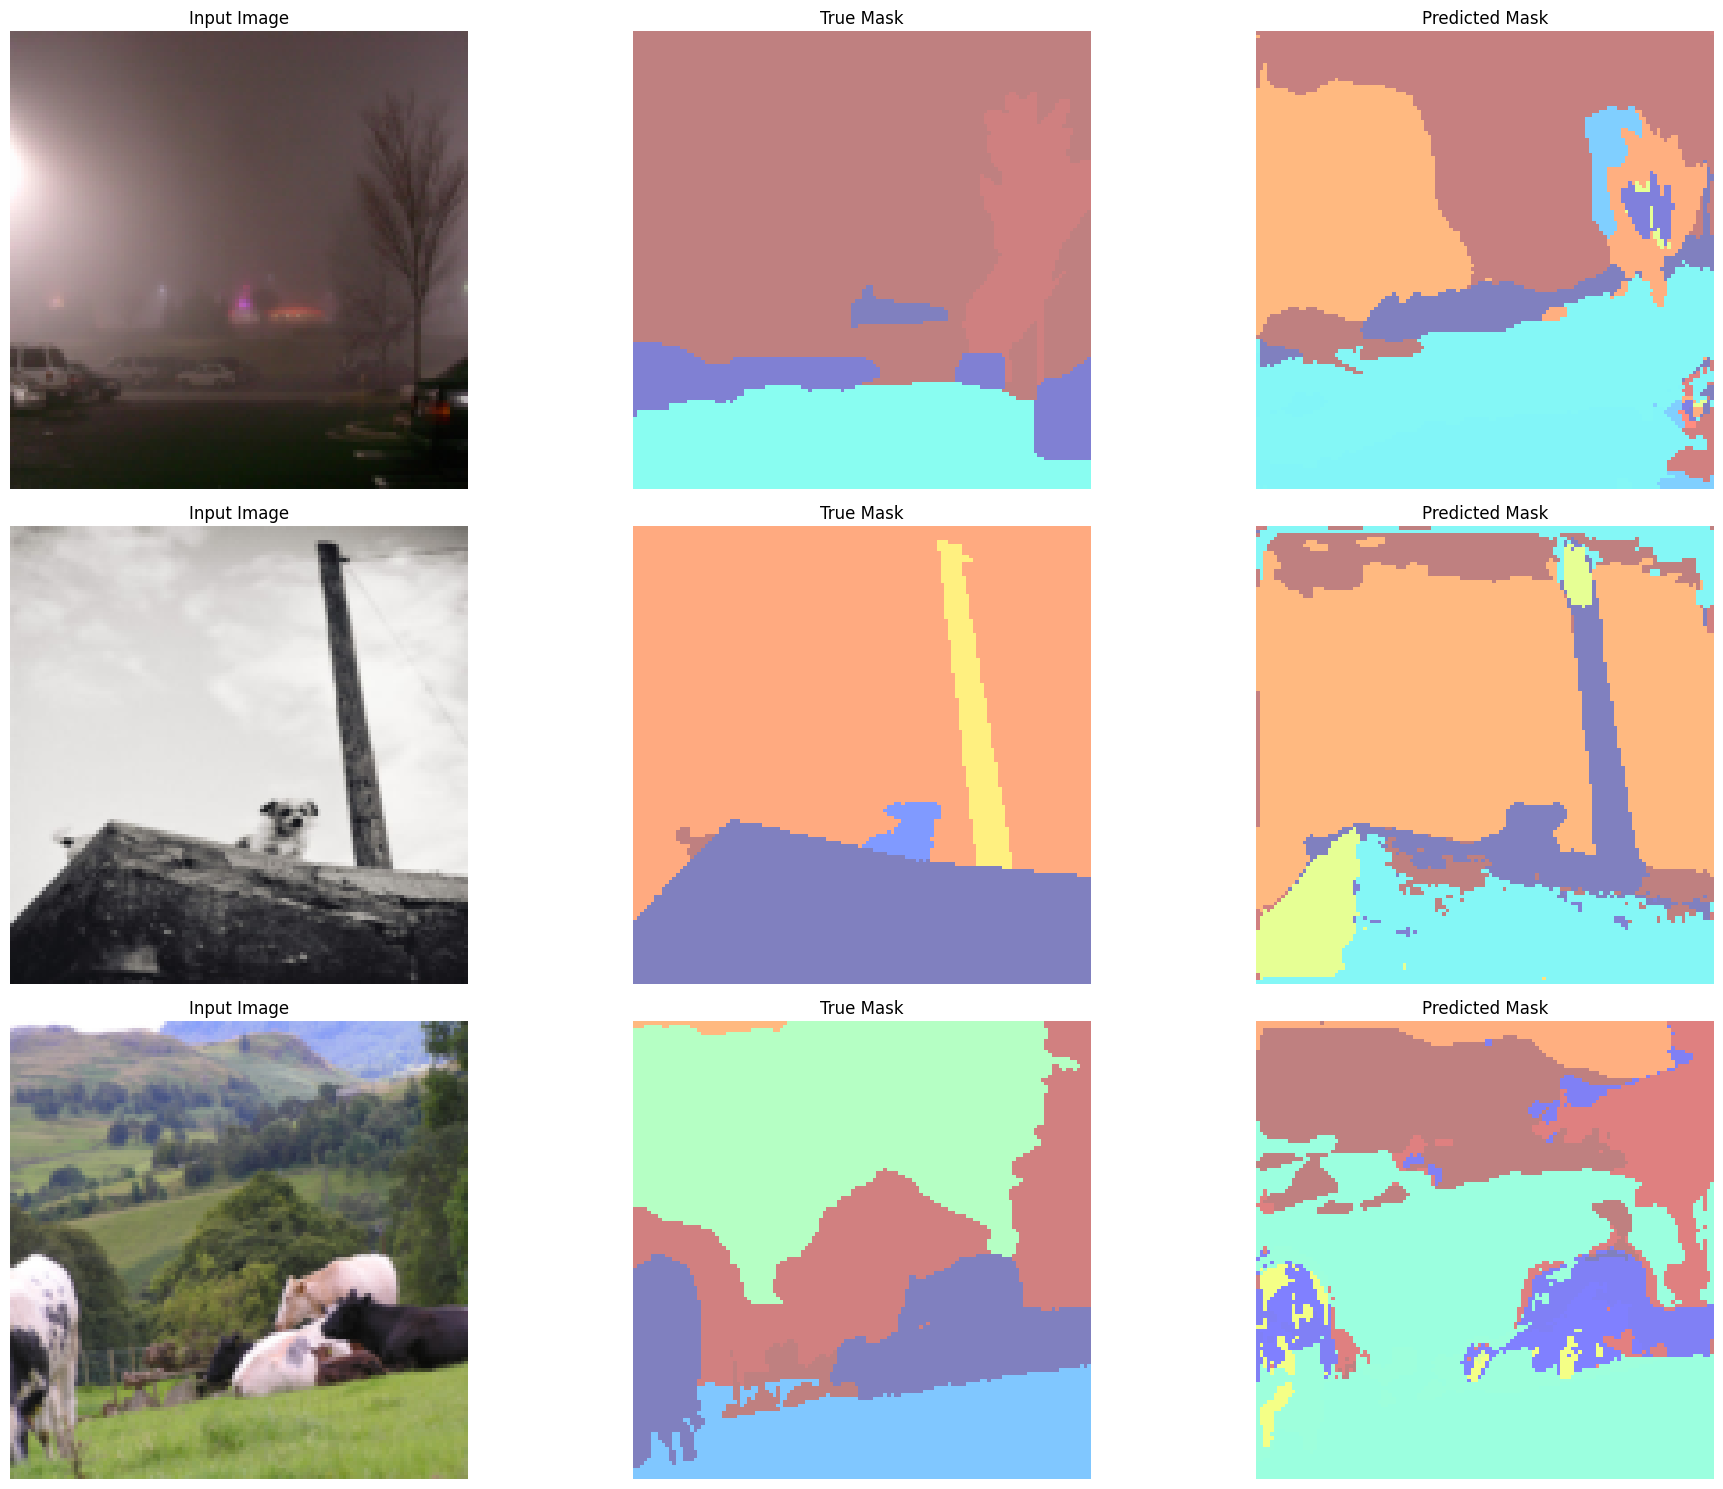

221/221 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.3238 - loss: 2.8033 - val_accuracy: 0.3200 - val_loss: 2.8086
Epoch 8/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3319 - loss: 2.7506
Epoch 8: saving model to unet_model_epoch_08_val_loss_2.7224.keras

Evaluating on test data at the end of epoch 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


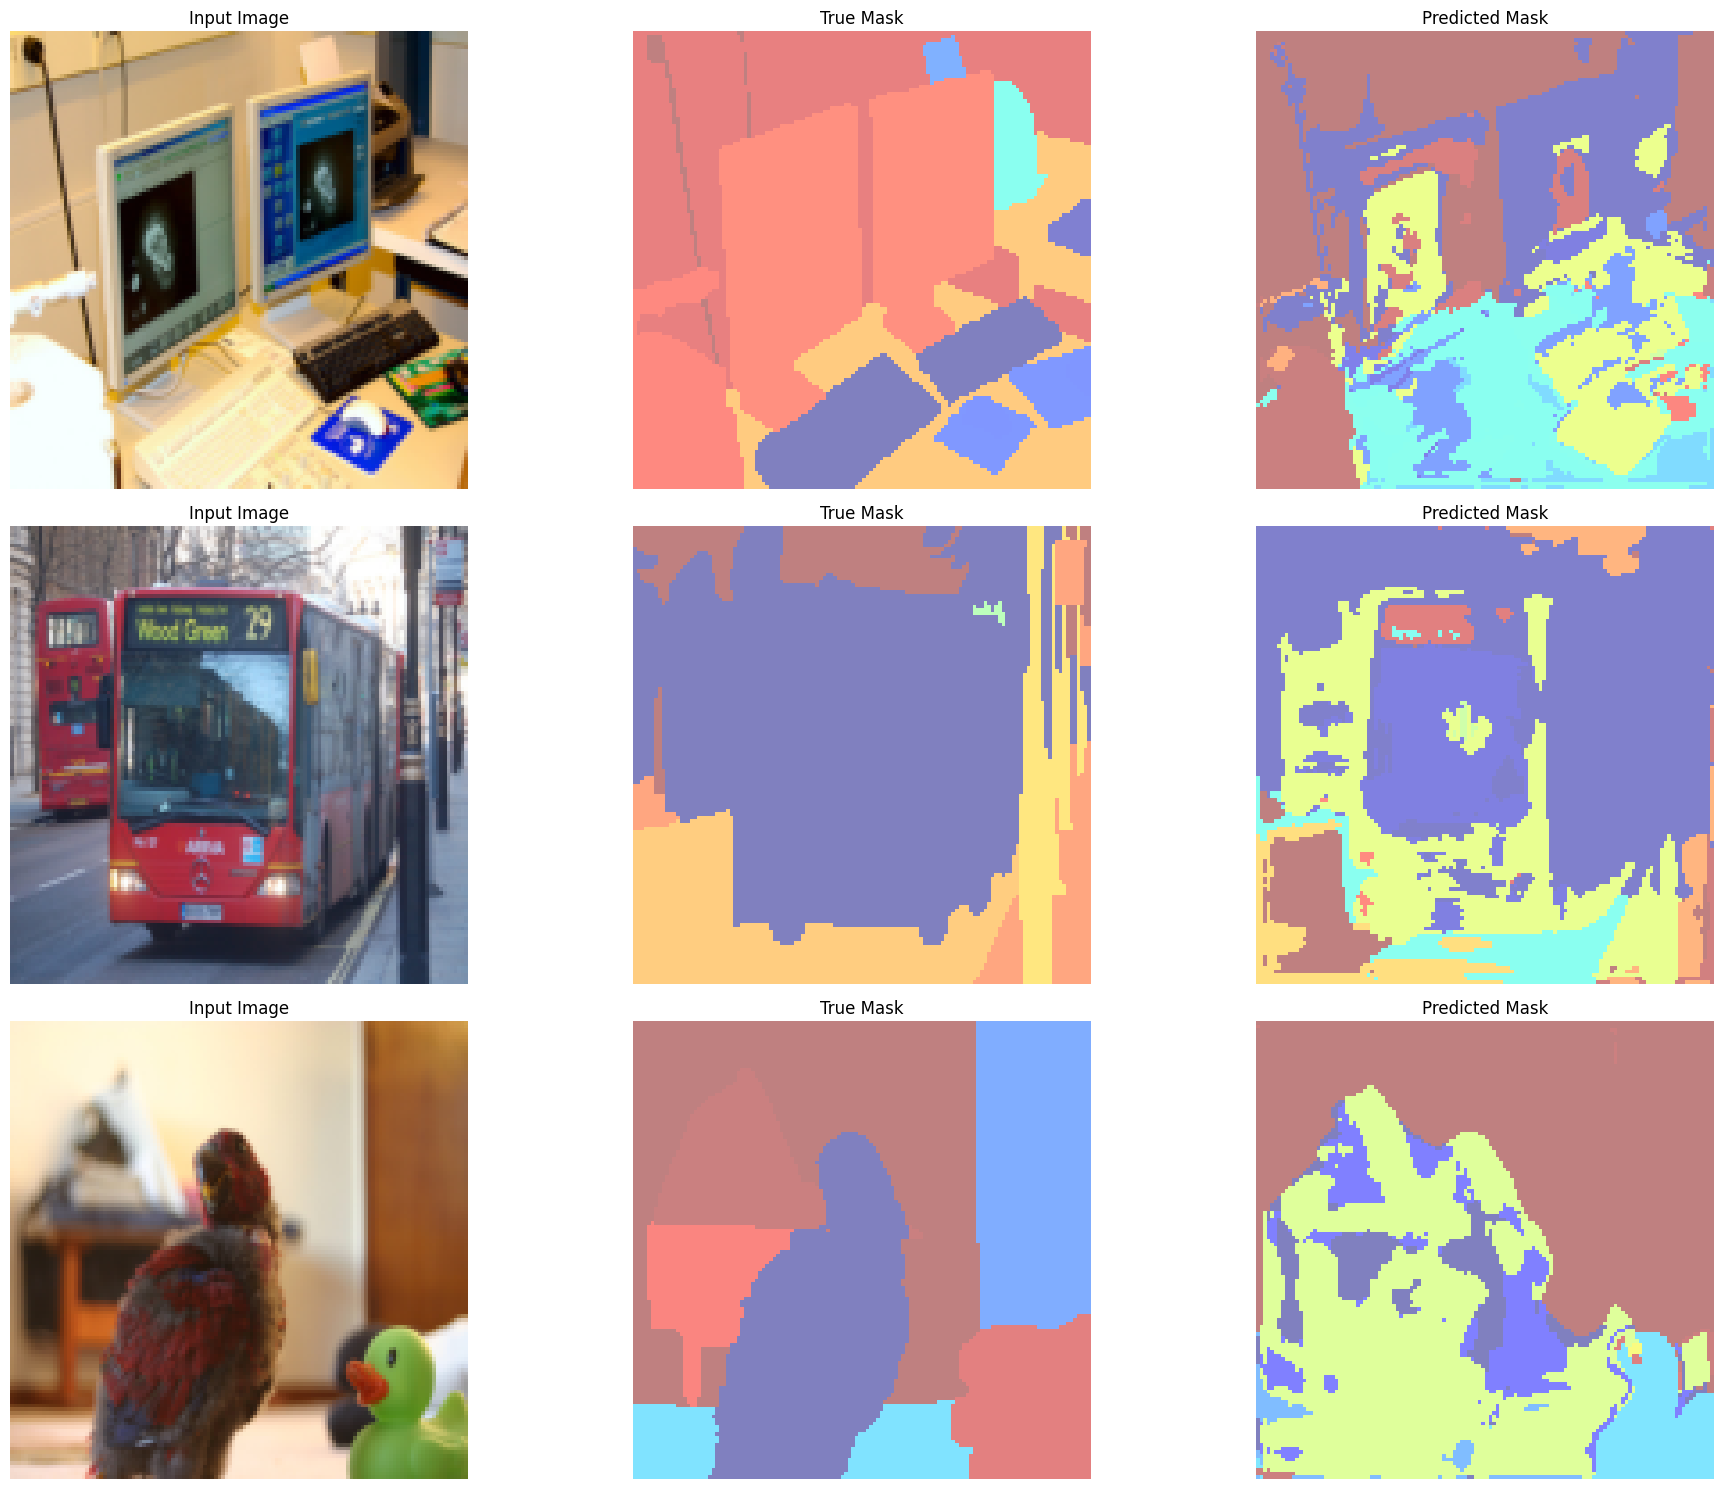

221/221 ━━━━━━━━━━━━━━━━━━━━ 555s 3s/step - accuracy: 0.3319 - loss: 2.7505 - val_accuracy: 0.3405 - val_loss: 2.7224
Epoch 9/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3460 - loss: 2.6672
Epoch 9: saving model to unet_model_epoch_09_val_loss_2.7083.keras

Evaluating on test data at the end of epoch 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


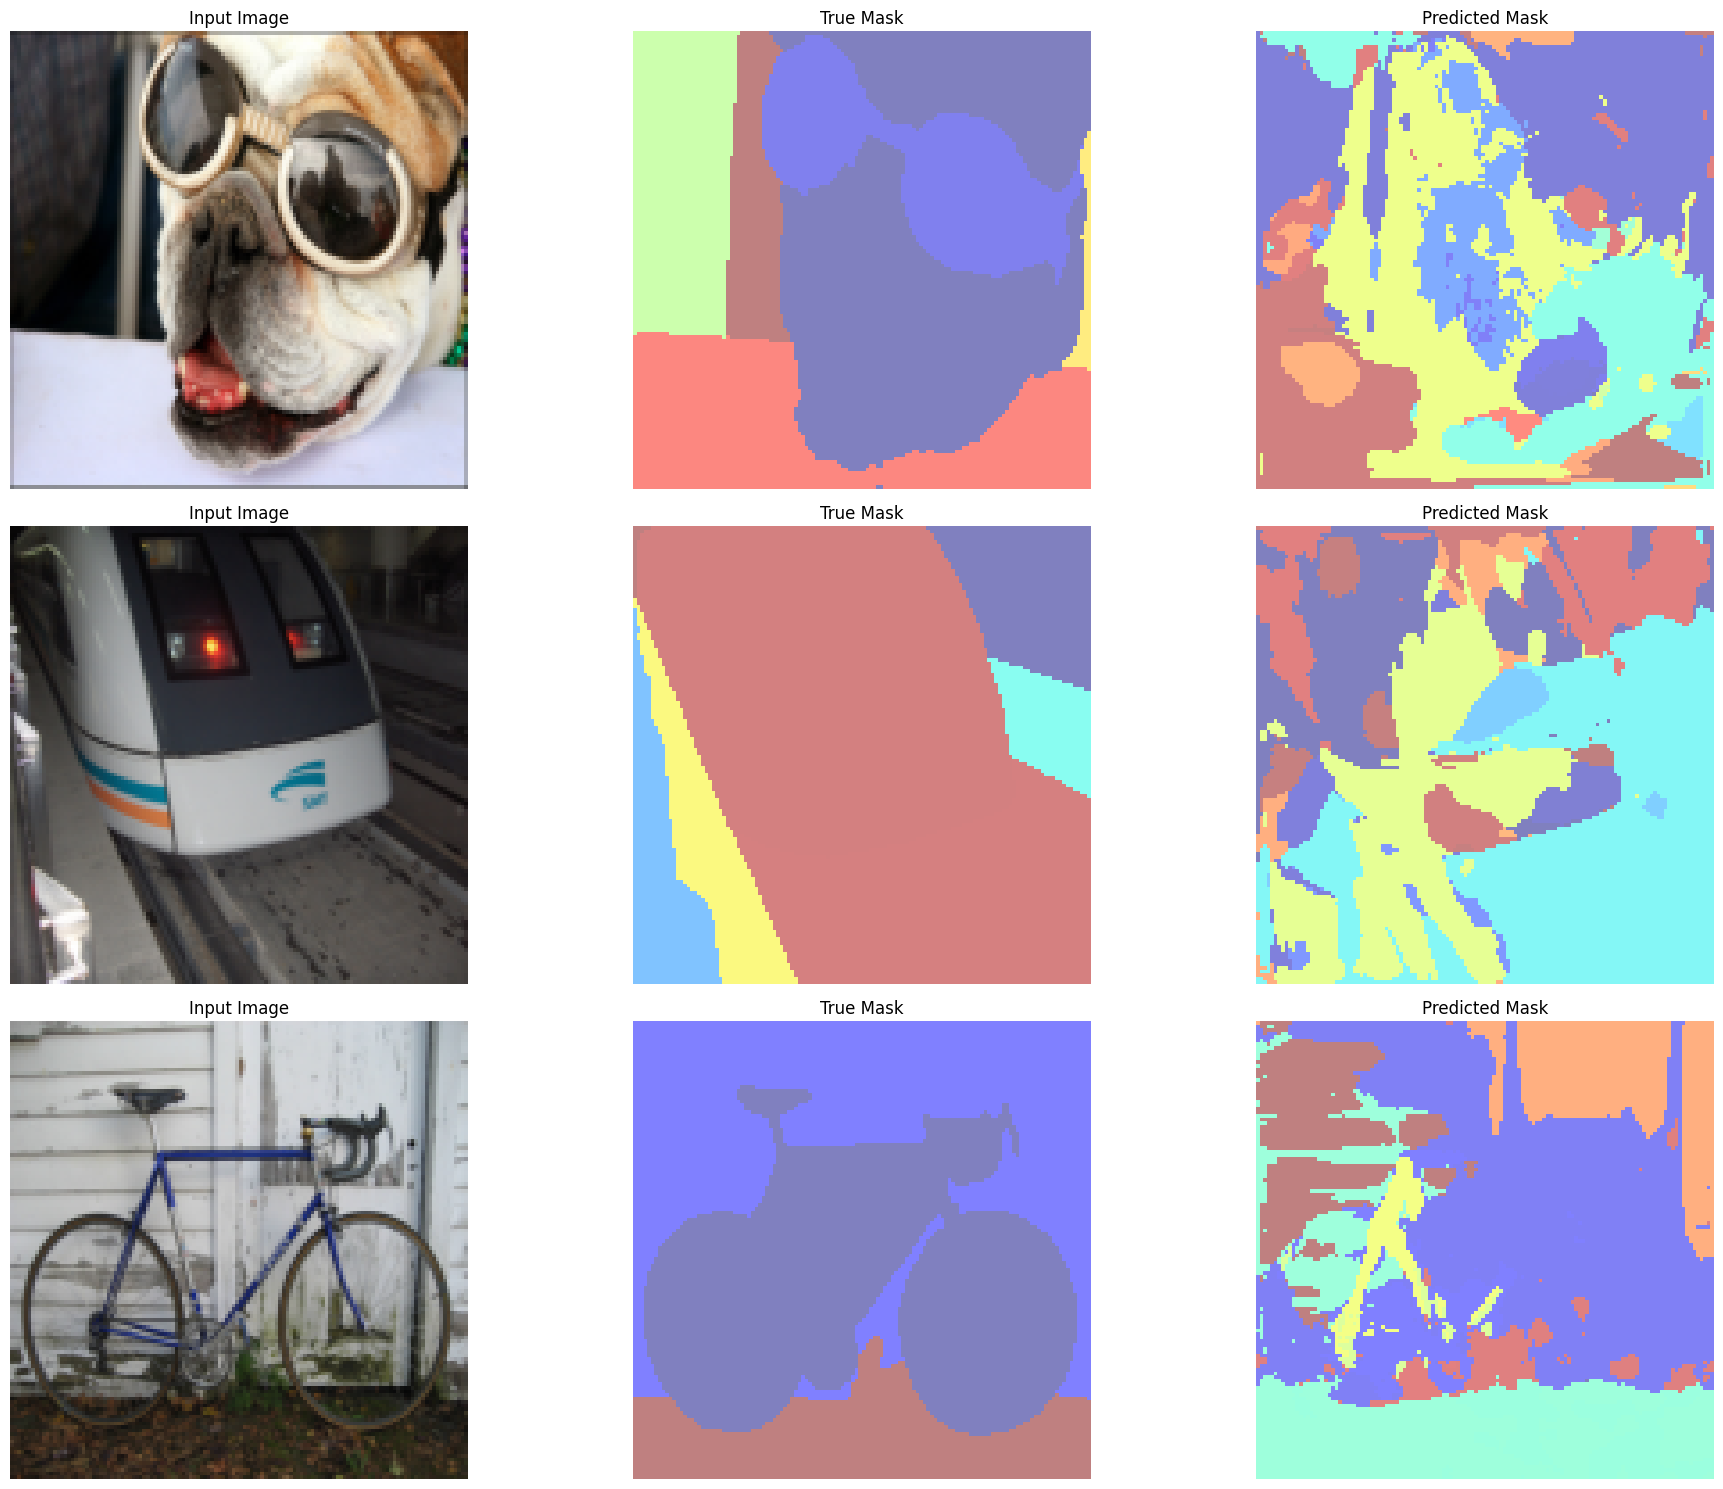

221/221 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.3460 - loss: 2.6671 - val_accuracy: 0.3426 - val_loss: 2.7083
Epoch 10/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3579 - loss: 2.6067
Epoch 10: saving model to unet_model_epoch_10_val_loss_2.6536.keras

Evaluating on test data at the end of epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


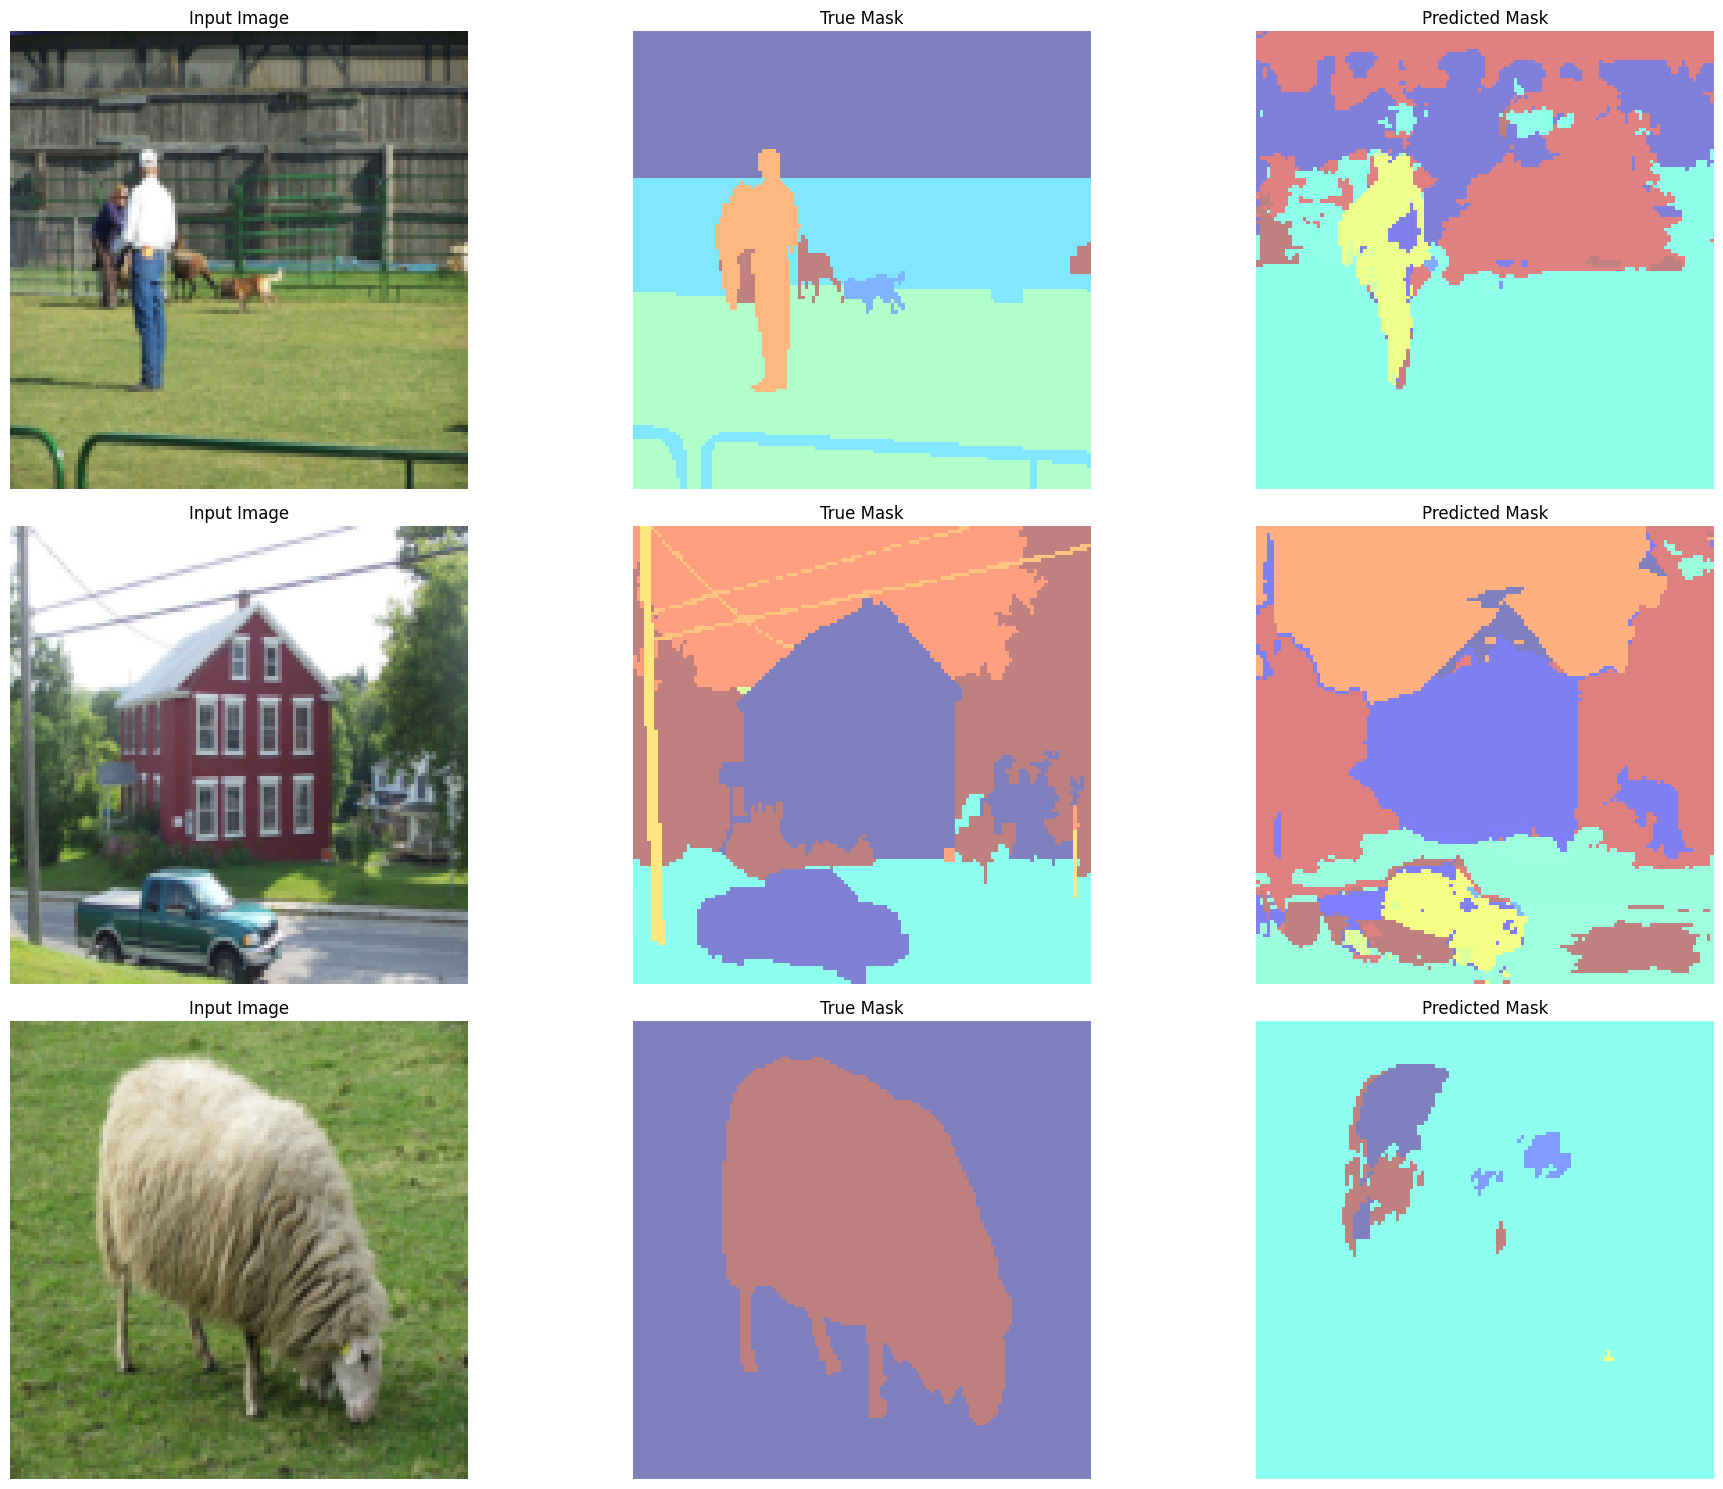

221/221 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.3579 - loss: 2.6065 - val_accuracy: 0.3546 - val_loss: 2.6536


In [ ]:
# Train the model with both callbacks
model.fit(
    train_gen,
    steps_per_epoch=len(train_image_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_image_paths) // batch_size,
    epochs=10,
    callbacks=[checkpoint_callback, test_callback]  # Add both the checkpoint and test callbacks here
)

## Save The model into Drive

In [ ]:
drive_dir = 'drive/MyDrive/UNET/'
model.save(drive_dir + 'UNet_Image_Segmentation.keras')

## Model link
You can access to the model: [Link](https://drive.google.com/file/d/17cuIPezQ-dBxGRQR-UgOxPtBxtwPH8r1/view?usp=sharing)

## Load the saved model

In [ ]:
model = load_model(drive_dir + 'UNet_Image_Segmentation.keras')

## Define IoU calculation function

In [ ]:
# Define IoU calculation function
def mean_iou(y_true, y_pred, num_classes):
    y_true = np.argmax(y_true, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    ious = []
    for c in range(num_classes):
        true_class = (y_true == c)
        pred_class = (y_pred == c)

        intersection = np.logical_and(true_class, pred_class).sum()
        union = np.logical_or(true_class, pred_class).sum()

        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in mean IoU
        else:
            ious.append(intersection / union)

    return np.nanmean(ious)  # Compute mean IoU ignoring NaN values

# Function to evaluate mean IoU on test data
def evaluate_mean_iou(model, test_gen, num_steps, num_classes):
    ious = []

    for _ in range(num_steps):
        test_images, test_masks = next(test_gen)
        predicted_masks = model.predict(test_images)

        for true_mask, pred_mask in zip(test_masks, predicted_masks):
            iou = mean_iou(true_mask, pred_mask, num_classes)
            ious.append(iou)

    return np.nanmean(ious)


In [ ]:
# Evaluate mean IoU on the test set
num_test_steps = len(test_image_paths) // batch_size
mean_iou_score = evaluate_mean_iou(model, test_gen, num_test_steps, num_classes)
print(f"Mean IoU on test data: {mean_iou_score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━